___


# Section 1: Introduction
For the sake of clearness, we divided our analysis mainly into four parts: __price, reviews, guest__, and __host__. In the whole project deliverable, we will display our analysis and milestones based on the sequence.

## <u>Overview</u>
At the high level, we aim to **analyze and provide recommendations through our findings from different perspectives.**<br>

From the **host's** angle, we would like to know how they can improve their stays and fuel the business; and for **customers**, how to find satisfied accommodations with acceptable prices would be a topic we would like to focus on.<br>

We hope our findings can not only provide directions to our friends or family as guests when they are selecting airbnb in DC, but also provide insights to hosts to improve the airbnb stays condition. We believe that the answer to those questions may lead to a win-win situation for both airbnb users and hosts.

## <u>Dataset Description</u>
There are three main Airbnb raw datasets of _"Washington, D.C., District of Columbia, United States"_ from [*Inside Airbnb*](http://insideairbnb.com/get-the-data.html). <br>

* File Name: [listings.csv.gz](http://data.insideairbnb.com/united-states/dc/washington-dc/2020-03-18/data/listings.csv.gz) (We downloaded and named it "listings_DC_full.csv")<br>
 Description: Detailed Listings data for Washington, D.C. <br>
 Data Size: 9,330 rows × 106 columns <br><br>

* File Name: [listings.csv](http://data.insideairbnb.com/united-states/dc/washington-dc/2020-03-18/visualisations/listings.csv) (We downloaded and named it "listings_DC.csv")<br>
 Description: Detailed Listings data for Washington, D.C. <br>
 Data Size: 9,330 rows × 16 columns <br><br>
 
* File Name: [calendar.csv.gz](http://data.insideairbnb.com/united-states/dc/washington-dc/2020-03-18/data/calendar.csv.gz) <br>
Description: Detailed Calendar Data for listings in Washington, D.C. <br>
Data Size: 3,392,372 rows × 3 columns <br><br>


The dataset _listings.csv_ (1.6MB) contains 9329 accommodations with 16 columns which include some basic information: location information, host name, room type, the number of reviews, minimum nights limitation, etc.<br>

The other larger dataset (31.3MB), _listings.csv.gz_, contains 9329 accommodations with 106 different kinds of detailed features, which includes not only the basic information, but other detailed features that help us analyze deeper and wider: guests reviews scores (the total number of reviews, overall review scores, scores in various aspects), description (amenities, house rules, room space), time series data (the first host date, the first reviews date, the last reviews date), performance rate (response rate, acceptance rate, is a super host or not), just to name a few.<br>

Besides acquiring open source data sets on **_Inside Airbnb_** website. To increase the accuracy of prediction, inference, and make our findings more convincing, we also found additional resources include:<br>

* File Name: [Federal Holidays - all.csv](https://www.federalpay.org/resources/holidays/Federal%20Holidays%20-%20all.csv)
<br>Description: US Federal Holidays for the period between 2017 and 2030 <br>
Data Size: 140 rows × 3 columns <br><br>

* Crime Rate of Each Neighborhood from Areavibes<br>
Description: Annual Crime Cases Number measured by every 100K people<br>
Website URL: https://www.areavibes.com/washington-dc/neighborhoods/

___

# Section 2: Choice for Heavier Grading
We would like to be graded more on **Data Analysis.** The main reason may be our expectation to relate findings to our daily life. From the beginning of this project, knowing fun facts or gaining insights have always been our main focus and interests of this project. We expect we could utilize the result to generate insights on practical use. In this case, we may be able to know how to select where to live on Airbnb.<br>

Since we’ve decided to put more effort on **exploratory data analysis**. We analyzed from different perspectives, **hosts** and **guests**, and two main factors, **price** and guest **reviews**, to connect the relationship between both sides of the market.<br>

Therefore, our project schedule has been divided into mainly four parts, price, reviews, guest, and host. Also, to support our findings from the original data and to get a deeper understanding of how to utilize them with python, we gathered relevant resources and data from various sites.<br>

We believe that our analysis can completely answer the questions of why we are interested in and even shows more detailed work beyond basic data analysis.

---

# Section 3: Data Analysis

In [1]:
import re
from numpy import nan as NA
import numpy as np
import pandas as pd
import datetime as dt
import statistics as st

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator
import plotly.express as px

pd.set_option('max_colwidth', 150)
pd.set_option('max_rows',7000)
pd.set_option("max_columns",1000)
plt.rcParams.update({'font.size': 15})

path = 'C:\\D\\Python\\BUDT758X\\Project\\'

In [2]:
# Read 2 listings data and merge them into single dataset: df
listings1 = pd.read_csv(path + 'listings_DC.csv')
listings2 = pd.read_csv(path + 'listings_DC_full.csv')

Airbnb_DC_merged = pd.merge(listings1, listings2, how='inner', left_on = 'id', right_on = 'id')
df = pd.merge(listings1, listings2, how='inner', left_on = 'id', right_on = 'id')

# Show columns with over 1000 missing values and its number of missing values 
isnull =  pd.DataFrame(df.isnull().sum())
col = isnull[isnull[0]>1000]
# drop column with all values are NA
df.dropna(how ="all", inplace = True,axis = 1)

# drop duplicate columns 
df.drop(columns=["name_x", "host_id_x", "host_name_x", "neighbourhood_x", "latitude_x", "longitude_x",
                 "room_type_x", "minimum_nights_x", "number_of_reviews_x", "last_review_x",
                 "reviews_per_month_x", "calculated_host_listings_count_x", "availability_365_x"], inplace=True)
df.reset_index(drop=True)

# fill NaN as Not provided 
df.fillna("Not provided",inplace=True)
df.reset_index(drop=True)
df.to_csv(path + 'Lastest.csv', index=False)

In [3]:
# Read calendar dataset
calendar = pd.read_csv(path + 'calender.csv', usecols = ['listing_id', 'date', 'price'])
calendar['date']= pd.to_datetime(calendar['date']) 
calendar['price'] = calendar['price'].replace('[$,]', '', regex=True).astype(float)

# Read holiday dataset
holidays = pd.read_csv(path + 'Federal Holidays - all.csv')
holidays = holidays.dropna()
holidays['Observed Date']= pd.to_datetime(holidays['Observed Date'])

## 1. How do holidays matter when booking Airbnbs?

First, we'll focus on the effect of **_Holidays_** on **_Price_** of the Airbnbs in Washington D.C. <br>
We are curious about if there are some specific holidays that may have more impact on the price of Airbnb and to what extent. At the first thought, we guessed that price tends to be higher on Christmas and the New Year, but it is suprising that the result we've got in our analysis is quite different from our understandings.<br>

To analyze **how it brings the benefit to the hosts** of Airbnb, we want to know how the **price changes** on holidays. For example, on average, by what percentage the Airbnb price would increase on a hoiliday? After that, we may be able to know how much the host may add to the price and give a **brief knowledge to the customers** who plan to visit D.C. on holidays.<br>

We merged **_calendar_** and **_holidays_** data and focused on columns `Holiday Name` and `price`. Then, we calculated the percentage change of price of "price on non-holiday" and "price on each holiday" from those columns, so that we can compare the impact of different holidays.<br>

Following is our analysis to generate the result. We will explain in more detailed and quantify the impact of the holidays on the price of Airbnbs in D.C.<br>

In [4]:
# merge datasets
cal_hol_merge = pd.merge(calendar, holidays, how='left', left_on = 'date', right_on = 'Observed Date')

# Define "Not Holiday" as a new category for Holiday Name
cal_hol_merge['Holiday Name'] = cal_hol_merge['Holiday Name'].fillna('Not Holiday')

cal_hol_merge.drop(columns=['Observed Date', 'Day of Week'],inplace = True)
cal_hol_merge.head(2)

,listing_id,date,price,Holiday Name
0,9097,2020-03-18,42.0,Not Holiday
1,9097,2020-03-19,42.0,Not Holiday


First take a look at the price distribution of all Airbnb listed. <br>
From the histogram, we know that distribution is highly right-skewed. There's price almost $15,000 per night, which we thought that it may be an outlier.

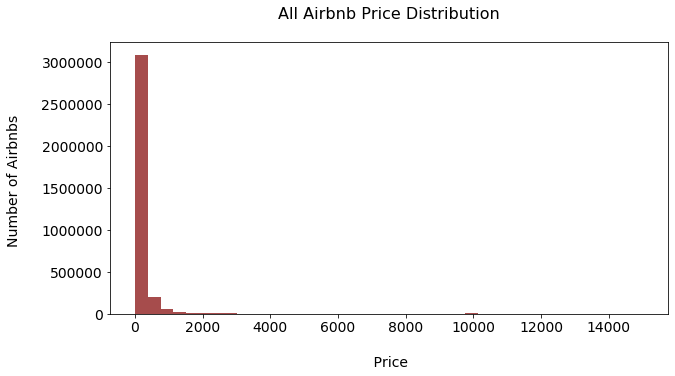

In [5]:
# Histogram for the price distribution of all Airbnb listed

plt.figure(figsize=(10,5))
plt.hist(cal_hol_merge.price, bins=40, alpha = 0.7, color='maroon')
plt.title("All Airbnb Price Distribution\n", fontsize=16)
plt.xlabel('\n Price', fontsize=14)
plt.ylabel('Number of Airbnbs \n', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [6]:
cal_hol_merge['price'].describe()

count    3.392372e+06
mean     2.021428e+02
std      4.609335e+02
min      1.000000e+01
25%      7.600000e+01
50%      1.170000e+02
75%      1.910000e+02
max      1.500000e+04
Name: price, dtype: float64

Therefore, to avoid outliers, we only want the data that are within 2 standard deviations, which we think the prices are more reasonable.

In [7]:
# Calculate the price of 2 standard deviations
m_2std = cal_hol_merge['price'].describe()['mean'] + 2*cal_hol_merge['price'].describe()['std'] 

In [8]:
# Airbnb listed within 2 standard deviations
cal_hol_merge = cal_hol_merge[cal_hol_merge.price<m_2std]
cal_hol_merge['price'].describe()

count    3.340827e+06
mean     1.639470e+02
std      1.557568e+02
min      1.000000e+01
25%      7.500000e+01
50%      1.150000e+02
75%      1.850000e+02
max      1.124000e+03
Name: price, dtype: float64

Again, we generate the histogram for the price distribution and it's more suitable for our analysis.

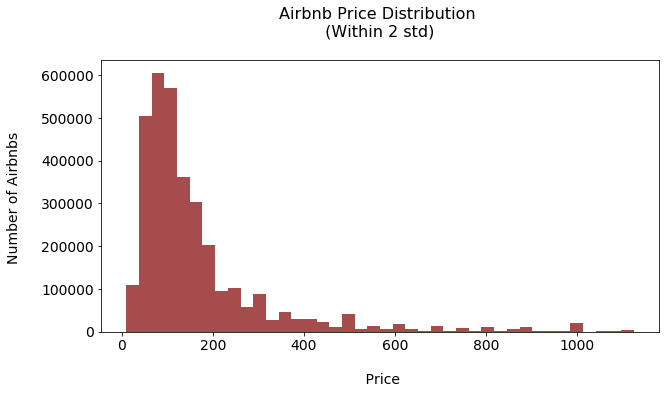

In [9]:
plt.figure(figsize=(10,5))
plt.hist(cal_hol_merge.price, bins=40, alpha = 0.7, color='maroon')
plt.title("Airbnb Price Distribution \n (Within 2 std) \n", fontsize=16)
plt.xlabel('\n Price', fontsize=14)
plt.ylabel('Number of Airbnbs \n', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Now, we can calculate the **percentage change of price between average price on each holiday and non-holiday.** <br>
We focus on the percentage changes to see the increase rate tendency since we think it is the proper way to understand how the holiday influence the price. 

In [10]:
avg_price_df = cal_hol_merge.groupby(by='Holiday Name').mean()
avg_price_df = avg_price_df.reset_index().sort_values("price", ascending = False)
avg_price_df.drop(columns=['listing_id'],inplace = True)

# average price on non-holiday
avg_price_not_hol = avg_price_df.price[7]

# calculate the percentage change of price between average price on each holiday and non-holiday
avg_price_df['price_diff_perc'] = (avg_price_df['price'] - avg_price_not_hol)/avg_price_not_hol
avg_price_df.head(2)

,Holiday Name,price,price_diff_perc
0,"Birthday of Martin Luther King, Jr.",172.789725,0.054279
3,Independence Day (observed) †,170.679328,0.041403


After that, we can now visualize the result.

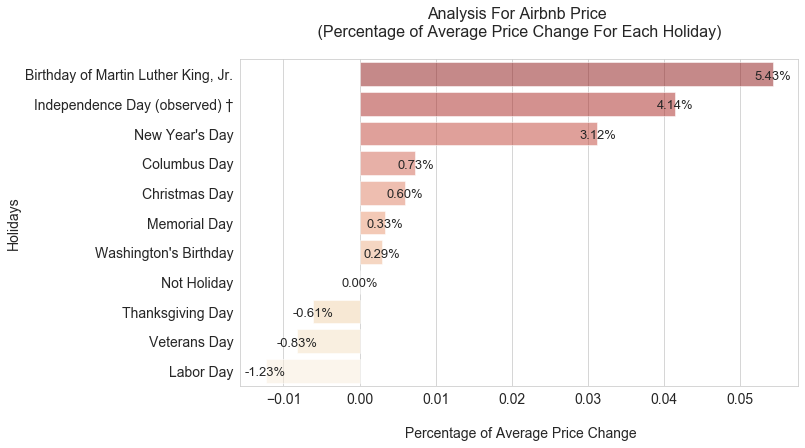

In [11]:
plt.figure(figsize=(10,6))
title = "Analysis For Airbnb Price \n (Percentage of Average Price Change For Each Holiday) \n"
sns.set_style('whitegrid')
axes = sns.barplot(x=avg_price_df['price_diff_perc'], y=avg_price_df['Holiday Name'], alpha = 0.5, palette="OrRd_r")
axes.set_title(title, fontsize=16)

plt.xlabel('\n Percentage of Average Price Change', fontsize=14)
plt.ylabel('Holidays', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for bar, price in zip(axes.patches, avg_price_df['price_diff_perc']):
    text_x = bar.get_width()
    text_y = bar.get_y() + bar.get_height() / 1.2
    text = f'{price:.2%}'
    axes.text(text_x, text_y, text, 
              fontsize=13, ha='center', va='bottom')

From the graph, we can observe whether the price is decrease or increase on particular holidays compare to that on non-holiday.<br>

Here are our __observations and insights:__
* 1. Price on **Birthday of Martin Luther King, Jr.** increases by approximately **5.43%**, followed by **Independence Day**, which increases by approximately **4.14%** than on non-holiday. It may have more demand on those holidays, so for the host, it should be a good time to promote themselves. As for the customers, they can know the average price difference and consider their budget if they plan to visit D.C. on those holidays.
* 2. Though the prices on Christmas and the New Year, which we thought would have large impact, increase as well, it's not that much as Birthday of Martin Luther King, Jr. and Independence Day. This is the part that different from our previous thoughts.
* 3. We think it may because D.C. is not that popular for celebrating New Year and therefore the price would not increase a lot. However, Birthday of Martin Luther King, Jr. is important for D.C. since as we know, "I Have a Dream" is delivered at speech the Lincoln Memorial in Washington, D.C. 

## 2. Which price range has extreme evaluation?

We found that airbnb price has a huge range, from mediocre stays to luxury one; from $30 to $15000 per night. We then would like to know whether most of the high-end accomondation performed well and received high reviews; and whether majority of the low-class stays got low scores maybe due to lack of amenities and services. Through this analysis, maybe the idea could provide to Airbnb for them to notice which airbnbs should be improved or what promotion should they come up with.

First, in order to remain the whole dataframe for other analysis, we subset the original dataset to a small one which only contains severals columns we need for the later analysis. There are two kinds of review scores in the dataset, `review scores in each categories` and `review ratings`. We have tried both and plotted, however, we found that the pattern are basically similar to each other, therefore, in thie deliverable, we only domonstrated analysis using `review scores in each categories`.

Also, we added a new column `price_per`, which is price per night per person to try shortening the gap among the price range. In this way, it would make more sense when we explain the idea.

In [12]:
#Calculate price per person
price_per = [round(x/y, 2) for x, y in zip (df['price_x'], df['accommodates'])]
price_per = pd.Series(price_per)
df['price_per'] = price_per.values

#Convert price_per to float
df['price_per'] = df['price_per'].astype(float)

In [13]:
#create a subset dataframe which contains columns we need
nei_overall = df.loc[:,('host_is_superhost', 'price_per', 'review_scores_accuracy', \
                  'review_scores_cleanliness', 'review_scores_checkin', \
                  'review_scores_communication', 'review_scores_location', 'review_scores_value')]

In the data cleaning process, we have imputed the missing values as `Not provided` and there's no other way to infer review scores in a specific category of those missing data. Thus, in the next step, we need to drop rows if there is any category contained `Not provided`. Before doing so, converting those columns values into string type would be needed for the next string process step.

After cleaning those missing values rows, we then need to convert them back to float data type for aggregation.

In [14]:
#Convert all categories of review scores to string
nei_overall.loc[:,('review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', \
                  'review_scores_communication', 'review_scores_location', 'review_scores_value')] = \
nei_overall.loc[:,('review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', \
                  'review_scores_communication', 'review_scores_location', 'review_scores_value')].astype(str)

#filter out not provided and convert the rest of them into float data type
nei_overall = nei_overall[~nei_overall.review_scores_accuracy.str.contains("Not provided", na=False)]
nei_overall = nei_overall[~nei_overall.review_scores_cleanliness.str.contains("Not provided", na=False)]
nei_overall = nei_overall[~nei_overall.review_scores_checkin.str.contains("Not provided", na=False)]
nei_overall = nei_overall[~nei_overall.review_scores_communication.str.contains("Not provided", na=False)]
nei_overall = nei_overall[~nei_overall.review_scores_location.str.contains("Not provided", na=False)]
nei_overall = nei_overall[~nei_overall.review_scores_value.str.contains("Not provided", na=False)]

#Convert all categories of review scores to float
nei_overall.loc[:,('review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', \
                  'review_scores_communication', 'review_scores_location', 'review_scores_value')] = \
nei_overall.loc[:,('review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', \
                  'review_scores_communication', 'review_scores_location', 'review_scores_value')].astype(float)

We would like to add each fields' review scores as an overall scores, which will make full scores into 60 points. However, there maybe lack of idea of measuring the scores, for example, readers would not know whether 40 points can counted as a good score. Thus, we normalized the overall scores into an out-of 100 points scale and plotted.

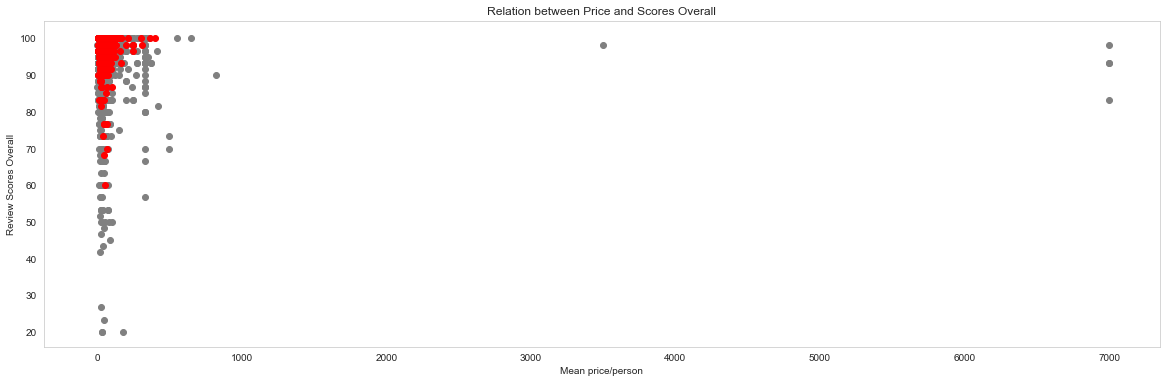

In [15]:
#Normalize the overall score into out of 100 scale
overall = nei_overall['review_scores_accuracy']+nei_overall['review_scores_cleanliness']+nei_overall['review_scores_checkin']+nei_overall['review_scores_communication']+nei_overall['review_scores_location']+nei_overall['review_scores_value']
overall = pd.Series(overall)
nei_overall['review_scores_overall'] = overall.values
nei_overall['review_scores_overall'] = nei_overall['review_scores_overall']/60*100

#Divide into super host and not super host
re_sup = nei_overall[nei_overall['host_is_superhost']=='t']
re_nsup = nei_overall[nei_overall['host_is_superhost']=='f']

#Plot
plt.figure(figsize=(20,6))
plt.grid(b=None)
plt.scatter(re_nsup['price_per'], re_nsup['review_scores_overall'], color = 'Grey')
plt.scatter(re_sup['price_per'], re_sup['review_scores_overall'], color = 'Red')
plt.title('Relation between Price and Scores Overall')
plt.xlabel('Mean price/person')
plt.ylabel('Review Scores Overall')
plt.show()

We can now visualize the output. In the scatter plot, since there are outliers, we can not have an clear overview of the pattern. Therefore, some adjust would be necessarily. After looking back to the dataset, we decided to drop those outliers with price per person over $100. And see if the visualization would be better to understand.

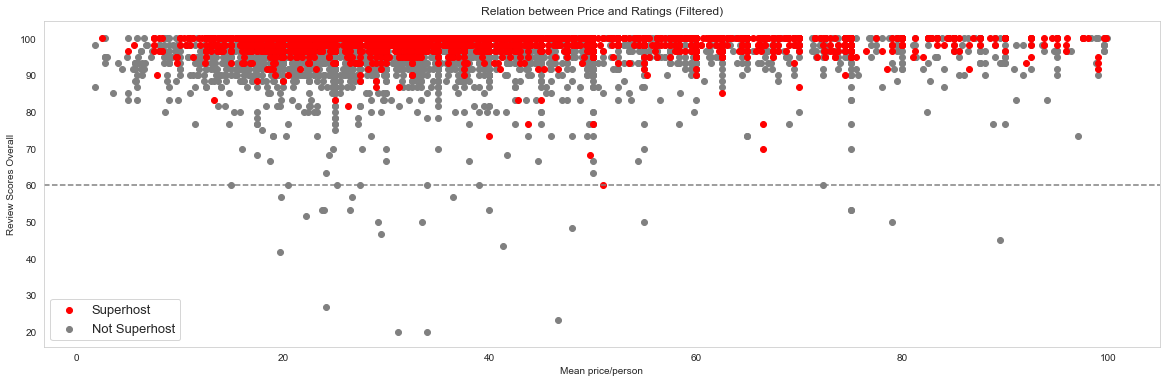

In [16]:
#Again, filter out outliers
re_sup_f = re_sup[re_sup['price_per']<100]
re_nsup_f = re_nsup[re_nsup['price_per']<100]


#After dropping outliers, plot again
plt.figure(figsize=(20,6))
plt.grid(b=None)

nsup = plt.scatter(re_nsup_f['price_per'], re_nsup_f['review_scores_overall'].dropna(), color='grey')
sup = plt.scatter(re_sup_f['price_per'], re_sup_f['review_scores_overall'].dropna(), color='Red')
plt.title('Relation between Price and Ratings (Filtered)')
plt.xlabel('Mean price/person')
plt.ylabel('Review Scores Overall')
plt.axhline(y=60, color='grey', linestyle='--')
plt.legend((sup, nsup),
           ('Superhost', 'Not Superhost'),
           loc='lower left',
           ncol=1,
           fontsize=13)

plt.show()

The graph becomes more readable. In this scatterplot, we also added a third dimension which is `host_is_superhost`, indicating that whether a host has been awarded as a superhost or not. A horizontal line has been added as well to show the base (we set at 60 points out of 100) to measure if hosts performed at least to the base line. 

Here are our __findings:__
* 1. At relatively low-class or mediocre stays, all of the review scores are above 80 points, which is out of what we have expected. We inferred that guests may think "we have already pay less, so it's acceptable if those stays lack of some amenities.

* 2. At relatively high-end airbnb which is about $100 per person per night, they also have high scores which are all above 70 points. At this point, we inferred that those places are meant to provide "high class" environment. Therefore, there would be common for them to keep the standards.

* 3. Besides the two extreme ideas we have mentioned above, other points are spread out and right skewed to lower points. Airbnb can notice those listings and find out a strategy to improve airbnb overall performance. Furthmore, for the red dots (superhost), Airbnb can also check if all superhosts perform well.

## 3. What should a host pay more attention on to improve the overall review scores?
Accuracy, cleanliness, checkin, communication, location and value are considerations of cusotmers and also factors that affect the reviews. We conducted an analysis of how those factors influence review rating and overall scores. 

In [17]:
df= pd.read_csv(path + "Lastest.csv")

#filter out missing data in scores columns
df = df[~df.review_scores_accuracy.str.contains("Not provided")]
df = df[~df.review_scores_cleanliness.str.contains("Not provided")]
df = df[~df.review_scores_checkin.str.contains("Not provided")]
df = df[~df.review_scores_communication.str.contains("Not provided")]
df = df[~df.review_scores_location.str.contains("Not provided")]
df = df[~df.review_scores_value.str.contains("Not provided")]
#Convert datatype to numerical
df[['review_scores_accuracy']] = df[['review_scores_accuracy']].astype(float)
df[['review_scores_cleanliness']] = df[['review_scores_cleanliness']].astype(float)
df[['review_scores_checkin']] = df[['review_scores_checkin']].astype(float)
df[['review_scores_communication']] = df[['review_scores_communication']].astype(float)
df[['review_scores_location']] = df[['review_scores_location']].astype(float)
df[['review_scores_value']] = df[['review_scores_value']].astype(float)
df[['review_scores_rating']] = df[['review_scores_rating']].astype(float)

In [18]:
#create overall scores by adding all specific review scores 
overall = df['review_scores_accuracy']+df['review_scores_cleanliness']+df['review_scores_checkin']+df['review_scores_communication']+df['review_scores_location']+df['review_scores_value']
overall = pd.Series(overall)
#normalize the overall scores
df['review_scores_overall'] = overall.values
df['review_scores_overall'] = df['review_scores_overall']/60*100

In [19]:
#keep only review scores relaed data 
review_co=df[['review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value','review_scores_overall']]
review_co.head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,review_scores_overall
0,95.0,9.0,9.0,10.0,10.0,10.0,9.0,95.000000
1,97.0,10.0,10.0,10.0,10.0,9.0,10.0,98.333333
2,87.0,9.0,9.0,9.0,9.0,10.0,9.0,91.666667
3,92.0,9.0,9.0,10.0,10.0,8.0,9.0,91.666667
5,85.0,8.0,8.0,9.0,9.0,8.0,8.0,83.333333


In [20]:
#correlation of score factors with overall scores
focus_cols = ['review_scores_overall','review_scores_rating']
CorrelationMatrix=review_co.corr().filter(focus_cols).drop(focus_cols)
CorrelationMatrix

,review_scores_overall,review_scores_rating
review_scores_accuracy,0.836862,0.753506
review_scores_cleanliness,0.750195,0.681169
review_scores_checkin,0.722366,0.578747
review_scores_communication,0.754483,0.625071
review_scores_location,0.608747,0.438517
review_scores_value,0.831785,0.742247


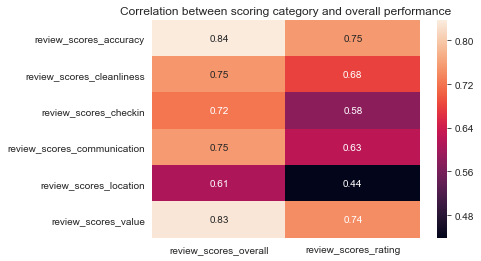

In [21]:
#CorrelationMatrix Visualization
sns.heatmap(CorrelationMatrix, annot=True)
plt.title('Correlation between scoring category and overall performance')
plt.show()

With the correlation matrix, we generated three following __observations:__
* 1. Overall ratings and scores in each category are highly **positively correlated.**
* 2. We can see that the socres of accuracy and of value are the top two most correlated variables with both overall review scores and review ratings, Their correlations coeffciencts with overall scores and ratings are approx. 0.8 and 0.7 respectively. 
* 3. Cleanliness and Communication have fair postive correlations with ratings and overall scores.
* 4. Surprisingly, although location is still positively correlated with rating and scores, its coeffcienct is the lowest. location seems not to be as important as other factors. Similarly, checking score has the lowest coeffcienct with ratings, but still highly correlated with overall scores.
    
Here is our __insights:__
* 1. As what we expected, accuracy, cleanliness, checkin, communication, location and value all influence the ratings and overall scores. The increase of these factors will make the ratings and overall review scores go up. By improving the quality of serives according to these factors would level up overal review scores and ratings.
* 2. Specifically, hosts should **update the housing info and make sure descriptions and photos accuratly represent the housing stays.** The price of stays should **provide good values and meet expectations of guests.** These two improvments would likely boost the reviews scores and rating the most. Also, cleanliness, check-in and communication experiences are important as well. Location seems to be the one factor that is hardly improve since it's physically here, but it affects the scores and ratings the least among all factors. Guests should put emphasis on improving the rest of factor performances.         

# 4. What is the better way to promote Airbnb?
For airbnb host, guests preference and the insights from guest are quite valuable. By knowing this, we can help the host to increase the revenue based on the guests likes, such as the guests preference of location, neighborhoods or property type. If the host's objects meet most of the guest likes, it will be booked out fully very soon.<br>

There are various choices for guests to select when it comes to choosing airbnb. We would like to know where do they prefer to live and which property type are the most popular? Do they prefer to live near the tourist attraction or they would rather live further with the lower price? 

In [22]:
df1 = df[["id", "name_y","number_of_reviews_y", "price_x","description"]]
df_pop_host = pd.DataFrame(df1.groupby("name_y")["number_of_reviews_y"].sum().sort_values(ascending = False).head(100))
df_pop_host = df_pop_host.reset_index()
df_pop_host.head()

,name_y,number_of_reviews_y
0,Efficiency suite in Capitol Hill,817
1,Private Suite in Capitol Hill Home,707
2,Cozy Cabin in the City on Cap Hill,655
3,Downtown DC Private Carriage House,592
4,Cozy Private Suite,563


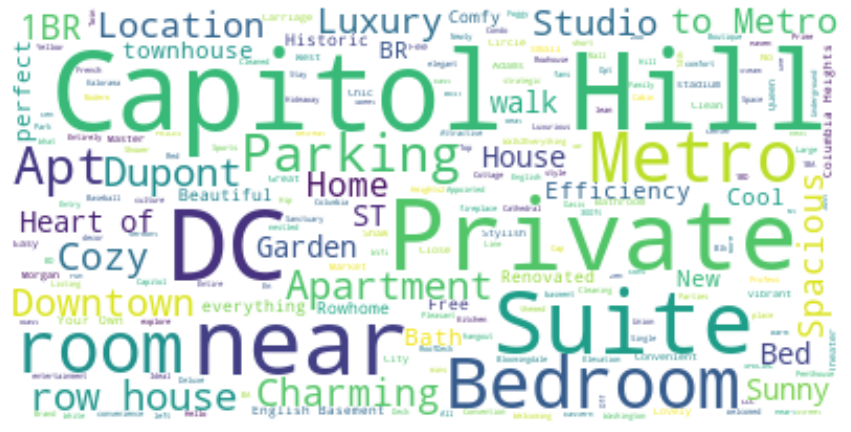

In [23]:
# Create a word cloud image for top 100 host:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in df_pop_host["name_y"])
wordcloud = WordCloud(max_words=200, background_color="white").generate(text)
plt.figure(figsize=(15,10))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

* These are the top 100 hosts most used words on the name of airbnb.
* Most used words: Capitol, Hill, Metro, Dupont, Luxury, Suite, Location, etc.

In [24]:
df_pool_host = pd.DataFrame(df1.groupby("name_y")["number_of_reviews_y"].sum().sort_values().head(100))
df_pool_host = df_pool_host.reset_index()
df_pool_host.head()

,name_y,number_of_reviews_y
0,Entire studio in the heart of DC!,1
1,Newly renovated 3 br home in quiet neighborhood,1
2,Newly renovated duplex 1 block from metro bus/rail,1
3,Charming private apartment in Capitol Hill,1
4,Charming home on M PLace,1


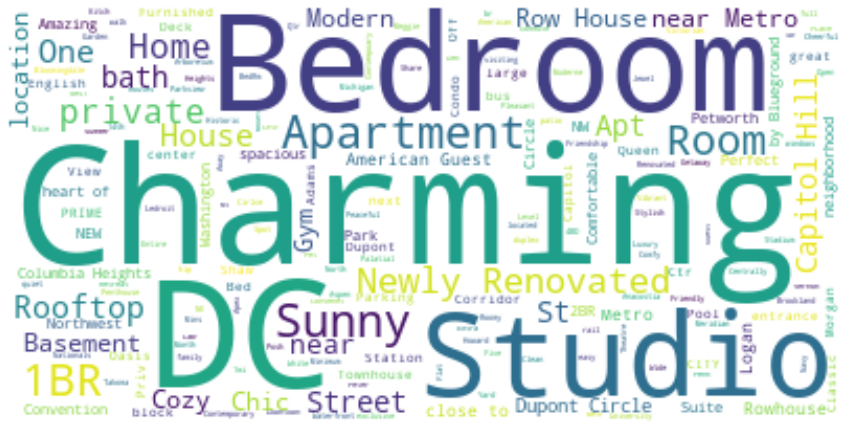

In [25]:
# Create a word cloud image for last 100 host:
from wordcloud import WordCloud, ImageColorGenerator
text = " ".join(str(each) for each in df_pool_host["name_y"])
wordcloud = WordCloud(max_words=200, background_color="white").generate(text)
plt.figure(figsize=(15,10))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Here is our __Insight:__
* We can see in the top 100 airbnb object name, most of the used words such as Metro, Private, Capitol hill, Location, Parking, etc. Most of the words are highly related to the **convenience of the location** and the **transporation.** 
* Those words on the wordcloud may be the key factors when a customer is choosing an Airbnb. We suggest that **a way for the host could do is to list such key words on the website** to attract guests. 
* However, we observed that the last 100 airbnb object name are lack of using these words. Perhaps due to this reason, guests won't be able to notice the, when they are searching for the accomomodation on the website.